In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

%matplotlib inline

In [2]:
def initMatrices(dim, num):
    # Initial guesses for h and vi
    h = np.ones((dim, dim)) * 128
    v = np.ones((num, dim, dim)) * 128
    return h, v

In [3]:
# Now vk is a 3 dimensional array, H is still 2D
def calcA_v(H, vk):
    H3 = np.tile(H, (np.shape(vk)[0], 1, 1))
    Vk = fft.fft2(fft.ifftshift(vk, axes = (1, 2)))
    return fft.fftshift(fft.ifft2(H3*Vk), axes = (1, 2))

def calcAHerm_v(Hadj, diff):
    xpad = diff
    X = fft.fft2(fft.ifftshift(xpad, axes = (1, 2)))
    return fft.fftshift(fft.ifft2(Hadj*X), axes = (1, 2))

def calcA_h(V, h):
    H = fft.fft2(fft.ifftshift(h))
    H3 = np.tile(H, (np.shape(V)[0], 1, 1))
    return fft.fftshift(fft.ifft2(H3*V), axes = (1, 2))

def calcAHerm_h(Vadj, diff):
    xpad = diff
    X = fft.fft2(fft.ifftshift(xpad, axes = (1, 2)))
    return np.sum(fft.fftshift(fft.ifft2(Vadj*X), axes = (1, 2)), axis = 0)


In [21]:
def gd_update(iterations, alpha_v, alpha_h, b, h):
    _, v = initMatrices(800, 4)
    
    for i in range(iterations):
        if i % 10 == 0:
            print(str(i) + "th iteration")
            
        # derivative w.r.t. v
        H = fft.fft2(fft.ifftshift(h))
        Hadj = np.conj(H)
        loss_v = calcA_v(H, v) - b
        _ = print(np.abs(np.sum(loss_v ** 2))) if i % 5 == 0 else 0
        v = v - alpha_v * np.real(calcAHerm_v(Hadj, loss_v))
        v = np.maximum(v, 0)
        # derivative w.r.t. h
        '''
        V = fft.fft2(fft.ifftshift(v, axes = (1, 2)))
        Vadj = np.conj(V)
        h = h - alpha_h * np.real(calcAHerm_h(Vadj, calcA_h(V, h) - b))
        h = np.maximum(h, 0)
        '''
        
    '''
    plt.figure()
    plt.title("final estimate for h")
    _ = plt.imshow(h, cmap='gray')
        
    for i in range(np.shape(v)[0]):
        plt.figure()
        plt.title("final estimate for v_" + str(i))
        _ = plt.imshow(v[i], cmap='gray')
    '''
        
    return h, v

In [5]:
def generate_single_b(h, v = None, num_points = 5):
    # generate light source with num_points
    if np.any(v) == None:
        v = np.zeros((800,800))
        points = np.random.randint(low=0, high=800, size=(num_points,2))
        # print(points)
        for point in points:
            v[tuple(point)] = 1

    # convolve light source with psf
    h_pad = np.pad(h, 400, mode='constant')
    v_pad = np.pad(v, 400, mode='constant')

    H_PAD = np.fft.fft2(np.fft.ifftshift(h_pad))
    V_PAD = np.fft.fft2(np.fft.ifftshift(v_pad))
    B = H_PAD * V_PAD

    b = np.fft.fftshift(np.fft.ifft2(B))
    b = np.abs(b)[400:1200, 400:1200].astype('uint8')
    
    return b

def generate_b(h, vs = None, num_samples = 4, num_points = 5):
    b = np.empty((num_samples, h.shape[0], h.shape[1]))
    for i in range(num_samples):
        b[i] = generate_single_b(h, num_points=num_points) if np.all(vs) == None else generate_single_b(h, vs[i], num_points)
    return b



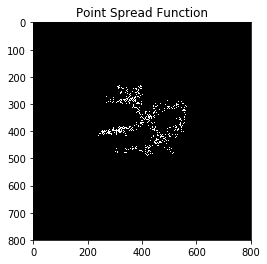

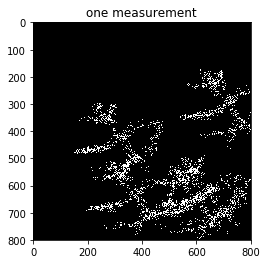

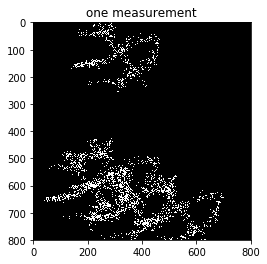

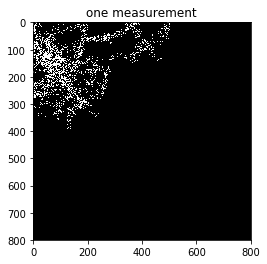

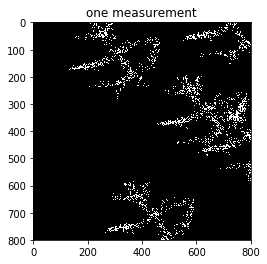

In [6]:
# Define h and v's here
h = np.asarray(Image.open('psf.png').convert('L'))
h = np.pad(h, 200, mode='constant')
plt.imshow(h, cmap = 'gray')
_ = plt.title('Point Spread Function')

points_array = np.array([
    [[343, 702],
     [679, 359],
     [699, 592],
     [469, 308],
     [665, 631]],
    [[601, 292],
     [732, 528],
     [717, 347],
     [645, 198],
     [154, 301]],
    [[266, 114],
     [182,  16],
     [113,  32],
     [235,  74],
     [ 59, 345]],
    [[756, 426],
     [463, 776],
     [367, 621],
     [ 51, 712],
     [162, 296]]
])

vs = np.zeros((4,800,800))

for i in range(len(points_array)):
    points = points_array[i]
    for point in points:
        vs[i][tuple(point)] = 1

b = generate_b(h, vs)

for i in range(4):
    plt.figure()
    plt.title('one measurement')
    _ = plt.imshow(b[i], cmap='gray')

In [7]:
H = fft.fft2(fft.ifftshift(h))
Hadj = np.conj(H)
alpha = np.real(1.8 / np.max(Hadj * H))
print('alpha: ' + str(alpha))
alpha = 1e-12
h_recovered, v_recovered = gd_update(200, alpha, alpha, b, h)

alpha: 5.814253497091783e-13
0th iteration
1.2984893829428392e+23
7435858779.0
8168707964.556085
6844255448.891813
7273204972.5811825
6419760482.6984
6645078003.652961
6113327204.243935
6208322475.2197075
5892301857.356072
10th iteration
5911664599.327748
5736029683.426887
5723553278.518812
5632662595.908666
5612511579.095981
5565875251.095023
5544560162.956145
5519963414.436571
5502488053.7203455
5487527729.490329
20th iteration
5474514101.514858
5462585193.468499
5451306667.929961
5440575881.802559
5430323274.469331
5420494100.691214
5411043182.763707
5401932694.423793
5393131563.9591465
5384611899.636888
30th iteration
5376351808.215482
5368329280.70048
5360525481.957213
5352928053.334284
5345524517.076135
5338302460.469481
5331248639.484188
5324350860.372195
5317600491.541133
5310987321.538531
40th iteration
5304504088.491984
5298144125.312724
5291900649.9285
5285768646.499301
5279743508.976172
5273819777.770277
5267991388.090144
5262255197.411746
5256606654.725594
5251040540.99870

In [15]:
def find_points(img):
    diff = np.max(img) - np.min(img)
    return np.argwhere(img > diff/2)

def display_results(h_recovered, v_recovered):
    for i in range(len(v_recovered)):
        plt.imshow(np.real(v_recovered[i]), cmap='gray')
        plt.figure()
        


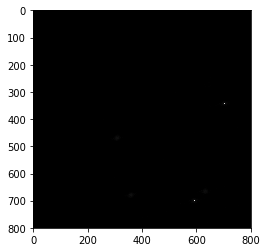

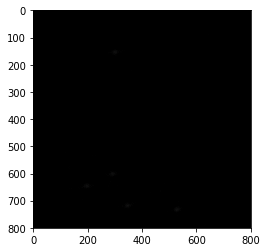

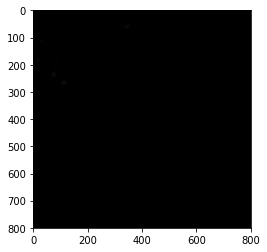

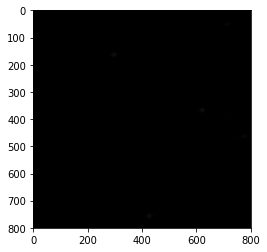

<Figure size 432x288 with 0 Axes>

In [16]:
display_results(h_recovered, v_recovered)